# Cancellation Analysis

## Overview:

We first quantified the contribution of each segment to total revenue loss. Naturally, not all issues can be addressed simultaneously, and businesses often prioritize interventions based either on ease of implementation or on the magnitude of financial impact.

While cancellations emerged as the single largest driver of loss, it is equally possible that, from a strategic perspective, the company may consider addressing supply-side gaps (e.g., “No Driver Found”) by increasing fleet size if that is the more immediately viable option.

However, since such strategic decisions lie outside the scope of this analysis, the focus of this project was narrowed to Cancellations, enabling a deeper exploration of their patterns and potential recovery opportunities.

From the initial demand and loss analysis, it was inferred that Cancellations (Driver + Customer) account for 65% of total contrbution to potentially lost revenue. For the purpose of this project, I dove deeper into the losses incurred due to cancellations. 

Driver and Customer cancellations and their effect were analysed separately by 3 categories: 

- What vehicles contribute to highest loss in revenue due to cancellations?
- What hours of the day see highest rates of cancellations and whats the revenue lost in those hours?

Based on the result, this project aims to identifu hotspots to that contribute to 70% of the cancellation losses and quantify the amount that could be recoverd, given the target is 50% recovery. These ssumptions were made to give the project a sense of realism and avoid the overestimation of capabilities.



In [ ]:
import numpy as np
import pandas as pd

In [ ]:
df= pd.read_csv(r"C:\Projects\Uber\data\raw\ncr_ride_bookings.csv")

In [ ]:
# Standardized column names
df = df.rename(columns={"Booking Status": "Status", "Booking Value": "RideValue"})
df['Status'] = df['Status'].str.lower().str.strip()

#  datetime column
df["request_datetime"] = pd.to_datetime(df["Date"] + " " + df["Time"], errors="coerce")


df = df.dropna(subset=["request_datetime"])

# Sort chronologically
df = df.sort_values("request_datetime").reset_index(drop=True)

df["month"] = df["request_datetime"].dt.to_period("M")
df["day_of_week"] = df["request_datetime"].dt.day_name()
df["hour"] = df["request_datetime"].dt.hour

In [ ]:

# ---- Hygiene: normalize text columns used for filtering ----
for col in ["Status", "Vehicle Type", "Pickup Location", "Drop Location"]:
    if col in df.columns:
        df[col] = df[col].astype(str).str.strip()

df["Status"] = df["Status"].str.lower()

# ---- Derive hour if timestamp exists ----
if "request_datetime" in df.columns:
    df["hour"] = pd.to_datetime(df["request_datetime"]).dt.hour
else:
    # fallback 
    assert "hour" in df.columns, "Provide 'request_datetime' or 'hour' column."

# ---- Completed fare distribution for MC sampling ----
completed_fares = df.loc[df["Status"] == "completed", "RideValue"].dropna().values
assert completed_fares.size > 0, "No completed fares found for simulation."


In [ ]:
def mc_estimate_sum(n_unmet: int, completed_fares: np.ndarray, n_iter: int = 20000, rng_seed: int = 42):
    """
    Monte Carlo estimate of lost revenue for 'n_unmet' rides using completed_fares as the proxy distribution.
    Returns mean and 95% CI (lower, upper).
    """
    rng = np.random.default_rng(rng_seed)
    sims = np.empty(n_iter, dtype=float)
    # Vectorized sampling: each iteration draws n_unmet samples and sums
    for i in range(n_iter):
        sims[i] = rng.choice(completed_fares, size=n_unmet, replace=True).sum()
    mean_est = sims.mean()
    ci_low, ci_high = np.percentile(sims, [2.5, 97.5])
    return mean_est, ci_low, ci_high


### Stratified Monte-Carlo Simulations: Estimates loss accounting for segment-wise distribution

In [ ]:
def mc_loss_by_segment(
    df: pd.DataFrame,
    cancel_filter: list,             # e.g., ["cancelled by driver"] OR ["cancelled by customer"]
    segment_col: str,                # e.g., "Vehicle Type" / "hour" / "Pickup Location" / "Drop Location"
    completed_fares: np.ndarray,
    min_unmet: int = 30,             # ignores tiny/noisy segments
    n_iter: int = 20000,
    rng_seed: int = 42
) -> pd.DataFrame:
    """
    Returns a ranked DataFrame with:
    segment, unmet_count, est_loss, ci_low, ci_high, loss_share, cum_share
    """
    # Subset to this cancellation type
    sub = df[df["Status"].isin([s.lower() for s in cancel_filter])]
    # Group unmet counts per segment
    counts = (sub.groupby(segment_col).size()
                .rename("unmet_count")
                .reset_index())
    # Filter small segments
    counts = counts[counts["unmet_count"] >= min_unmet].copy()
    if counts.empty:
        return pd.DataFrame(columns=[segment_col, "unmet_count", "est_loss", "ci_low", "ci_high", "loss_share", "cum_share"])

    # MC for each segment
    est_list = []
    for seg, n_unmet in counts[[segment_col, "unmet_count"]].itertuples(index=False):
        mean_est, ci_low, ci_high = mc_estimate_sum(int(n_unmet), completed_fares, n_iter=n_iter, rng_seed=rng_seed)
        est_list.append((seg, int(n_unmet), mean_est, ci_low, ci_high))

    out = pd.DataFrame(est_list, columns=[segment_col, "unmet_count", "est_loss", "ci_low", "ci_high"])
    out = out.sort_values("est_loss", ascending=False).reset_index(drop=True)

    # Shares & coverage curve
    total_loss = out["est_loss"].sum()
    out["loss_share"] = out["est_loss"] / total_loss if total_loss > 0 else 0.0
    out["cum_share"] = out["loss_share"].cumsum()
    return out


## Driver cancellation  loss by segments

The loss incurred due to Driver cancellations are segmented into hourly, vehicle type and pick up and drop locations.

By segmenting, it would be possible to identify the effect of each segment separately.

In [ ]:
driver_loss_by_vehicle = mc_loss_by_segment(
    df, cancel_filter=["cancelled by driver"], segment_col="Vehicle Type",
    completed_fares=completed_fares, min_unmet=30
)

driver_loss_by_hour = mc_loss_by_segment(
    df, cancel_filter=["cancelled by driver"], segment_col="hour",
    completed_fares=completed_fares, min_unmet=30
)

driver_loss_by_pickup = mc_loss_by_segment(
    df, cancel_filter=["cancelled by driver"], segment_col="Pickup Location",
    completed_fares=completed_fares, min_unmet=50
)

driver_loss_by_drop = mc_loss_by_segment(
    df, cancel_filter=["cancelled by driver"], segment_col="Drop Location",
    completed_fares=completed_fares, min_unmet=50
)

### Sanity check: Reaggregating segment losses to check if it still matches the global estimates. 



In [ ]:
total_driver_loss_vehicle= driver_loss_by_vehicle['est_loss'].sum()
total_driver_loss_hour=driver_loss_by_hour["est_loss"].sum()

print(total_driver_loss_vehicle)
print(total_driver_loss_hour)

The differences are tiny (<0.01%), proving that segment-level Monte Carlo simulations are consistent with the global estimates.

## Customer cancellation loss

In [ ]:
customer_loss_by_vehicle = mc_loss_by_segment(
    df, cancel_filter=["cancelled by customer"], segment_col="Vehicle Type",
    completed_fares=completed_fares, min_unmet=30
)

customer_loss_by_hour = mc_loss_by_segment(
    df, cancel_filter=["cancelled by customer"], segment_col="hour",
    completed_fares=completed_fares, min_unmet=30
)

customer_loss_by_pickup = mc_loss_by_segment(
    df, cancel_filter=["cancelled by customer"], segment_col="Pickup Location",
    completed_fares=completed_fares, min_unmet=50
)

customer_loss_by_drop = mc_loss_by_segment(
    df, cancel_filter=["cancelled by customer"], segment_col="Drop Location",
    completed_fares=completed_fares, min_unmet=50
)

In [ ]:
total_customer_loss_vehicle= customer_loss_by_vehicle['est_loss'].sum()
total_customer_loss_hour=customer_loss_by_hour["est_loss"].sum()

print(total_customer_loss_vehicle)
print(total_customer_loss_hour)

### Lorenz-Style Plot of Loss Distribution
What it is:
 A Lorenz-style plot shows the cumulative share of loss contributed by segments, ranked from highest to lowest.
- X-axis → Ranked segments (e.g., pickup or drop locations)
- Y-axis → Cumulative share of total estimated loss


Interpretation:
- If the curve rises steeply at first → a small number of segments contribute disproportionately (Pareto effect / hotspots).
- If the curve is close to a straight diagonal → losses are spread almost uniformly across all segments.

Insight from this data:
- The plot lies very close to the diagonal, showing no dominant locations.
- This suggests cancellations are distributed evenly across pickup and drop points, so isolating a few “top” locations would not meaningfully help target overall loss.


In [ ]:
def plot_cumulative(df, segment_col="Pickup Location", loss_col="est_loss", title="Cumulative Share of Loss"):
    grouped = df[[segment_col, loss_col]].sort_values(loss_col, ascending=False).reset_index(drop=True)
    grouped["cum_share"] = grouped[loss_col].cumsum() / grouped[loss_col].sum()

    fig, ax = plt.subplots(figsize=(10,6))

    # Line plot (cumulative share)
    ax.plot(grouped.index, grouped["cum_share"], color="red", marker="o", label="Cumulative share")

    # Reference line for perfect uniformity
    n = len(grouped)
    ax.plot(grouped.index, np.linspace(0,1,n), color="black", linestyle="--", label="Uniform distribution")

    ax.set_xlabel("Segments (ranked)")
    ax.set_ylabel("Cumulative Share of Loss")
    ax.set_ylim(0,1.05)
    ax.set_title(title)
    ax.legend()
    plt.show()

plot_cumulative(customer_loss_by_pickup, segment_col="Pickup Location", loss_col="est_loss",
                title="Cumulative Loss Share by Pickup Location(customer cancellation)")

plot_cumulative(customer_loss_by_drop, segment_col="Drop Location", loss_col="est_loss",
                title="Cumulative Loss Share by Drop Location (customer cancellation)")

plot_cumulative(driver_loss_by_pickup, segment_col="Pickup Location", loss_col="est_loss",
                title="Cumulative Loss Share by Pickup Location (driver cancellation)")

plot_cumulative(driver_loss_by_drop, segment_col="Drop Location", loss_col="est_loss",
                title="Cumulative Loss Share by Drop Location (driver cancellation)")



In [ ]:
def segments_to_hit_target(ranked_df: pd.DataFrame, target_share: float = 0.30, label_col: str = None):
    """
    From a ranked (desc est_loss) DataFrame with a 'cum_share' column,
    return the minimal set of segments that covers at least target_share of loss.
    """
    if label_col is None:
        # try to infer the first column name that is not metrics
        metric_cols = {"unmet_count", "est_loss", "ci_low", "ci_high", "loss_share", "cum_share"}
        label_col = [c for c in ranked_df.columns if c not in metric_cols][0]

    if ranked_df.empty:
        return ranked_df.copy()

    take_until = ranked_df[ranked_df["cum_share"] <= target_share]
    # include the first row that pushes it over the target
    if len(take_until) < len(ranked_df):
        take_until = pd.concat([take_until, ranked_df.iloc[[len(take_until)]]], ignore_index=True)
    return take_until[[label_col, "unmet_count", "est_loss", "loss_share", "cum_share"]]


## Segment wise loss accounting to 70% share of losses

#### Pareto-Based Narrowing

Within each segmentation, cancellation hotspots were identified using a 70% contribution threshold.

This ensured analytical focus on the relatively small subset of conditions that accounted for the majority of revenue loss.

#### Cross-Segmentation (Hour × Vehicle Type)

Hotspots were then combined at the intersection of hour of day and vehicle type, yielding granular “cells” where interventions could be targeted.

This enabled a two-dimensional prioritization:

- When cancellations were most costly.
- Where (in terms of vehicle type) the impact was greatest.

#### Target Setting

Although mathematically, full recovery from these hotspots was possible, such an assumption would be unrealistic operationally.

A more pragmatic target was set: 40% recovery of losses from these high-impact cells.

Even this level of recovery was considered ambitious yet achievable, balancing statistical optimism with business feasibility.


In [ ]:
target_70_vehicle = segments_to_hit_target(driver_loss_by_vehicle, target_share=0.70)
target_70_vehicle

In [ ]:
target_70_hour=segments_to_hit_target(driver_loss_by_hour, target_share=0.70)
target_70_hour

In [ ]:
target_70_pickup=segments_to_hit_target(driver_loss_by_pickup, target_share=0.70)
target_70_pickup

In [ ]:
target_70_dropoff=segments_to_hit_target(driver_loss_by_drop, target_share=0.70)
target_70_dropoff

## Customer cancellation related loss segments

In [ ]:
c_target_70_vehicle=segments_to_hit_target(customer_loss_by_vehicle, target_share=0.70)
c_target_70_vehicle

In [ ]:
c_target_70_hour=segments_to_hit_target(customer_loss_by_hour, target_share=0.70)
c_target_70_hour

In [ ]:
c_target_70_pickup=segments_to_hit_target(customer_loss_by_pickup, target_share=0.70)
c_target_70_pickup

In [ ]:
c_target_70_dropoff=segments_to_hit_target(customer_loss_by_drop, target_share=0.70)
c_target_70_dropoff


### Monte-Carlo Simulations to estimate two dimenstional loss (hour x vehicle type)

In [ ]:
def mc_loss_by_two_dims(
    df: pd.DataFrame,
    cancel_filter: list, 
    dim_a: str, dim_b: str, 
    completed_fares: np.ndarray,
    min_unmet: int = 25,
    n_iter: int = 20000,
    rng_seed: int = 42
) -> pd.DataFrame:
    """
    Returns a ranked table of (dim_a x dim_b) with unmet_count, est_loss, ci_low, ci_high, loss_share, cum_share.
    """
    sub = df[df["Status"].isin([s.lower() for s in cancel_filter])]
    counts = (sub.groupby([dim_a, dim_b]).size()
                .rename("unmet_count").reset_index())
    counts = counts[counts["unmet_count"] >= min_unmet].copy()
    if counts.empty:
        return pd.DataFrame(columns=[dim_a, dim_b, "unmet_count", "est_loss", "ci_low", "ci_high", "loss_share", "cum_share"])

    est_list = []
    for a, b, n_unmet in counts[[dim_a, dim_b, "unmet_count"]].itertuples(index=False):
        mean_est, ci_low, ci_high = mc_estimate_sum(int(n_unmet), completed_fares, n_iter=n_iter, rng_seed=rng_seed)
        est_list.append((a, b, int(n_unmet), mean_est, ci_low, ci_high))

    out = pd.DataFrame(est_list, columns=[dim_a, dim_b, "unmet_count", "est_loss", "ci_low", "ci_high"])
    out = out.sort_values("est_loss", ascending=False).reset_index(drop=True)
    total_loss = out["est_loss"].sum()
    out["loss_share"] = out["est_loss"] / total_loss if total_loss > 0 else 0.0
    out["cum_share"] = out["loss_share"].cumsum()
    return out


In [ ]:
driver_vehicle_hour = mc_loss_by_two_dims(
    df, cancel_filter=["cancelled by driver"],
    dim_a="Vehicle Type", dim_b="hour",
    completed_fares=completed_fares, min_unmet=20
)

# Top hotspots contributing most of cancellation-driven loss:
driver_vehicle_hour.head(15)

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Pivot into Vehicle x Hour grid
d_pivot = driver_vehicle_hour.pivot_table(
    index="Vehicle Type", columns="hour",values='loss_share', aggfunc="sum"
)

plt.figure(figsize=(14,6))
sns.heatmap(d_pivot, annot=False, fmt=".0f", cmap="Reds")
plt.title("Estimated loss share by vehicle type and hour(Driver Cancellations)\nSelected Vehicle × Hour Cells")
plt.ylabel("Vehicle Type")
plt.xlabel("Hour of Day")
plt.show()

In [ ]:
customer_vehicle_hour = mc_loss_by_two_dims(
    df, cancel_filter=["cancelled by customer"],
    dim_a="Vehicle Type", dim_b="hour",
    completed_fares=completed_fares, min_unmet=20
)

# Top hotspots contributing most of cancellation-driven loss:
customer_vehicle_hour.head(15)

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Pivot into Vehicle x Hour grid
heatmap = customer_vehicle_hour.pivot_table(
    index="Vehicle Type", columns="hour",values='loss_share', aggfunc="sum"
)

plt.figure(figsize=(14,6))
sns.heatmap(heatmap, annot=False, fmt=".0f", cmap="Reds")
plt.title("Estimated loss share by vehicle type and hour(Customer Cancellations)\nSelected Vehicle × Hour Cells")
plt.ylabel("Vehicle Type")
plt.xlabel("Hour of Day")
plt.show()

##### Final narrowing and Impact Optimisation


- Hotspot Prioritization

From the cells contributing to 70% of total loss, the Top 10 cells were selected.
These represent the most critical combinations of hour × vehicle type.

- Recovery Potential

Estimated recoverable amount by assuming 40% recovery from these Top 10 hotspots.
This conservative assumption balances feasibility with meaningful impact.

- Benchmarking Against Ground Truth

Compared potential recovery to total revenue from completed rides.
Provided a business context for the magnitude of recoverable loss.

- Revenue Uplift Estimation

Calculated daily and hourly average uplift, under the assumption that intervention achieves full success in recovering 40% from the targeted hotspots


In [ ]:
def plan_to_hit_target_2d(
    ranked_grid_df: pd.DataFrame,               # output of mc_loss_by_two_dims, sorted by est_loss desc
    target_share: float = 0.70,                 # e.g., recover 70% of driver-cancel loss
    assumed_reduction: float = 0.40            # e.g., reduce cancels by 40% in targeted cells
) -> pd.DataFrame:
    """
    Return the minimal set of cells to reach target share and the estimated recovered revenue
    assuming a fractional reduction in cancellations in those cells.
    """
    if ranked_grid_df.empty:
        return ranked_grid_df.copy()

    # take rows until reaching target_share
    take_until = ranked_grid_df[ranked_grid_df["cum_share"] <= target_share]
    if len(take_until) < len(ranked_grid_df):
        take_until = pd.concat([take_until, ranked_grid_df.iloc[[len(take_until)]]], ignore_index=True)
    plan = take_until.copy()

    # Recovery if we reduce cancellations by X% in those cells
    plan["recovered_est"] = plan["est_loss"] * assumed_reduction
    plan["cum_recovered"] = plan["recovered_est"].cumsum()
    return plan

In [ ]:
# Assume driver_vehicle_hour is your chosen action grid
plan_70 = plan_to_hit_target_2d(driver_vehicle_hour, target_share=0.70, assumed_reduction=0.40)  # e.g., 40% reduction where we intervene
plan_70.head(20)

# Summaries:
total_driver_cancel_loss = driver_vehicle_hour["est_loss"].sum()
est_recovered = plan_70["recovered_est"].sum()

print(f"Driver-cancel loss (MC est): ₹{total_driver_cancel_loss:,.0f}")
print(f"Targeting {len(plan_70)} Vehicle×Hour cells recovers ≈ ₹{est_recovered:,.0f} (assumes {int(100*0.50)}% reduction in those cells)")
print(f"Share of driver-cancel loss addressed: {est_recovered / total_driver_cancel_loss: .1%}")


In [ ]:
# Look at the selected cells
plan_70.sort_values("recovered_est", ascending=False).head(30)

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Pivot into Vehicle x Hour grid
heatmap_data = plan_70.pivot_table(
    index="Vehicle Type", columns="hour", values="recovered_est", aggfunc="sum"
)

plt.figure(figsize=(14,6))
sns.heatmap(heatmap_data, annot=True, fmt=".0f", cmap="Reds")
plt.title("Estimated Recoverable Revenue (Driver Cancellations)\nSelected Vehicle × Hour Cells")
plt.ylabel("Vehicle Type")
plt.xlabel("Hour of Day")
plt.show()

In [ ]:
c_plan_70 = plan_to_hit_target_2d(customer_vehicle_hour, target_share=0.70, assumed_reduction=0.50)  
c_plan_70.head(20)

# Summaries:
total_customer_cancel_loss = customer_vehicle_hour["est_loss"].sum()
est_recovered = c_plan_70["recovered_est"].sum()

print(f"Customer-cancel loss (MC est): ₹{total_customer_cancel_loss:,.0f}")
print(f"Targeting {len(c_plan_70)} Vehicle×Hour cells recovers ≈ ₹{est_recovered:,.0f} (assumes {int(100*0.50)}% reduction in those cells)")
print(f"Share of customer-cancel loss addressed: {est_recovered / total_customer_cancel_loss: .1%}")


In [ ]:
c_plan_70.sort_values("recovered_est", ascending=False).head(30)

In [ ]:
# Pivot into Vehicle x Hour grid
heatmap_data = c_plan_70.pivot_table(
    index="Vehicle Type", columns="hour", values="recovered_est", aggfunc="sum"
)

plt.figure(figsize=(14,6))
sns.heatmap(heatmap_data, annot=True, fmt=".0f", cmap="Reds")
plt.title("Estimated Recoverable Revenue (Customer Cancellations)\nSelected Vehicle × Hour Cells")
plt.ylabel("Vehicle Type")
plt.xlabel("Hour of Day")
plt.show()

## Immediate course of action

To further narrow down and enable immediate course of action, Top 10 cells were selected. 

In [ ]:
# top 10 for driver cancellations
top_driver = plan_70.sort_values("recovered_est", ascending=False).head(10)

# top 10 for customer cancellations
top_customer = c_plan_70.sort_values("recovered_est", ascending=False).head(10)

print("Top Driver Cancel Cells:")
print(top_driver)

print("Top Customer Cancel Cells:")
print(top_customer)


In [ ]:
# Heatmap for driver cancellations
pivot_driver = top_driver.pivot_table(
    index="Vehicle Type", columns="hour", values="recovered_est", aggfunc="sum", fill_value=0
)

plt.figure(figsize=(14,6))
ax = sns.heatmap(pivot_driver, cmap="Reds", linewidths=0.5, linecolor="gray",
                 cbar_kws={"label": "Estimated Loss (₹)"})

# overlay top 10 stars at correct grid coords
for _, row in top_driver.iterrows():
    if row["Vehicle Type"] in pivot_driver.index and row["hour"] in pivot_driver.columns:
        y = pivot_driver.index.get_loc(row["Vehicle Type"])
        x = pivot_driver.columns.get_loc(row["hour"])
        ax.text(
            x + 0.5, y + 0.5, "★",
            ha="center", va="center", color="white", fontsize=14
        )

plt.title("Top 10 Vehicle×Hour Cells – Driver Cancellation Loss", fontsize=16)
plt.xlabel("Hour of Day")
plt.ylabel("Vehicle Type")
plt.show()


# Heatmap for customer cancellations
pivot_customer = top_customer.pivot_table(
    index="Vehicle Type", columns="hour", values="recovered_est", aggfunc="sum", fill_value=0
)

plt.figure(figsize=(14,6))
ax = sns.heatmap(pivot_customer, cmap="Reds", linewidths=0.5, linecolor="gray",
                 cbar_kws={"label": "Estimated Loss (₹)"})

for _, row in top_customer.iterrows():
    if row["Vehicle Type"] in pivot_customer.index and row["hour"] in pivot_customer.columns:
        y = pivot_customer.index.get_loc(row["Vehicle Type"])
        x = pivot_customer.columns.get_loc(row["hour"])
        ax.text(
            x + 0.5, y + 0.5, "★",
            ha="center", va="center", color="white", fontsize=14
        )

plt.title("Top 10 Vehicle×Hour Cells – Customer Cancellation Loss", fontsize=16)
plt.xlabel("Hour of Day")
plt.ylabel("Vehicle Type")
plt.show()


### How much can be recovered by targetting the top 10 hotspots

In [ ]:
top_driver.to_csv("top_driver.csv", index=False)
top_customer.to_csv("top_customer.csv", index=False)


In [ ]:
total_recoverable= top_customer['recovered_est'].sum() + top_driver['recovered_est'].sum()

daily_average_recovered= total_recoverable/ 365
hourly_average_recovered= daily_average_recovered/24

# 1.completed rides
completed_rides = df[df["Status"] == "completed"]

# 2. Total revenue from completed rides
total_revenue = completed_rides["RideValue"].sum()

# 3. Daily average (divide by 365 for a full year)
daily_avg_revenue = total_revenue / 365

# 4. Hourly average (divide daily by 24)
hourly_avg_revenue = daily_avg_revenue / 24

print(f"Total 2024 Revenue (Completed rides): ₹{total_revenue:,.0f}")
print(f"Total Recoverable amount: {total_recoverable}" )
print(f"Average Daily Revenue: ₹{daily_avg_revenue:,.0f}")
print(f"Average Hourly Revenue: ₹{hourly_avg_revenue:,.0f}")





In [ ]:
# Uplift

daily_uplift=(daily_average_recovered/daily_avg_revenue)*100

hourly_uplift=(hourly_average_recovered/hourly_avg_revenue)*100

print("Daily uplift % :",daily_uplift)
print("Hourly uplift %:", hourly_uplift)

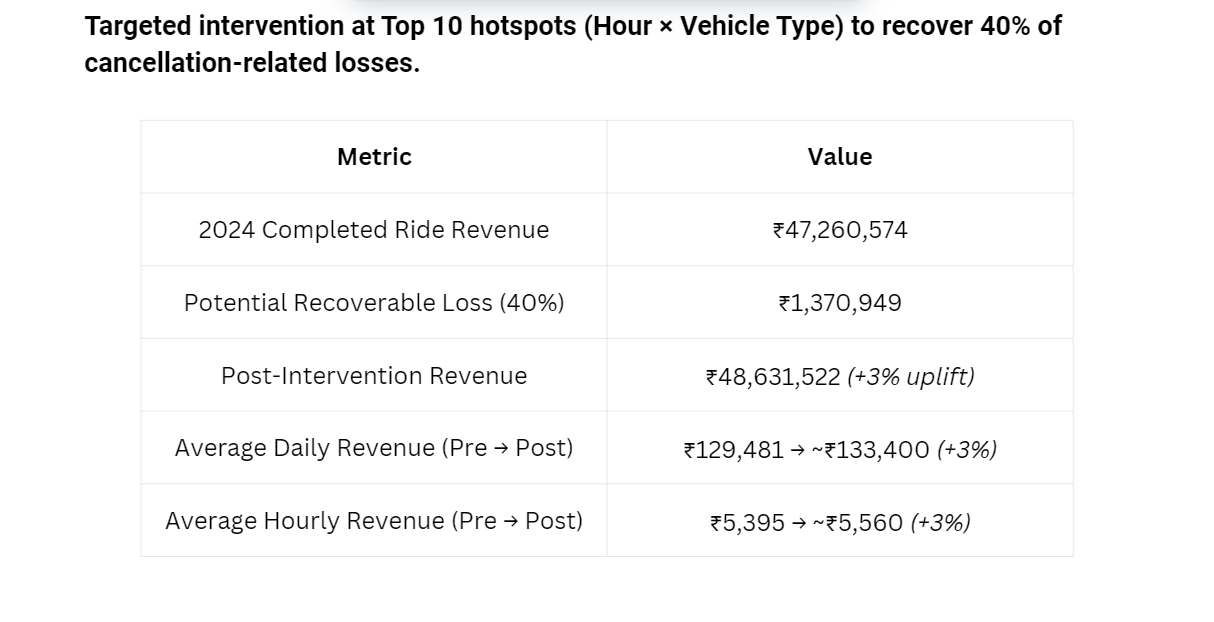